In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
file_name =  "/content/drive/My Drive/traffic sign recognition/dataset/megalo.zip"

with ZipFile(file_name, "r") as zip:
    zip.extractall()
    print("Done")

Done


In [3]:
path = "/content/GTSRB/Training"
labelFile = "/content/drive/My Drive/traffic sign recognition/dataset/signnames.csv"

steps_per_epoch_val = 2000   #has to be equal to the length of the dataset divided by the batch size so cant define it now


testRatio = 0.2
validationRatio = 0.2

In [4]:
# IMPORTING TRANING DATA
import cv2
import numpy as np
import os

path = '/content/Train'
images = []
classNo = []
myList = os.listdir(path)
noOfClasses = len(myList)
print("Total classes Detected: ", noOfClasses)
print("Importing classes....")
for x in range(0, noOfClasses):
    myPicList = os.listdir(f"{path}/{x}")
    for y in myPicList:
        curImg = cv2.imread(f"{path}/{x}/{y}")
        resImg = cv2.resize(curImg, (32, 32))
        images.append(resImg)
        classNo.append(x)
    print(x, end = " ")
print(" ")
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)
print(images[1].shape)
print(classNo)


Total classes Detected:  43
Importing classes....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
(39209, 32, 32, 3)
(32, 32, 3)
[ 0  0  0 ... 42 42 42]


In [5]:
# Split my traing data to validation and traing
from sklearn.model_selection import train_test_split

validationRatio = 0.25
X_train, X_validation, y_train, y_validation = train_test_split(images, classNo, test_size = validationRatio)


IMPORTING TESTING DATASET

In [6]:
# read csv for testing

import pandas as pd

labelFile = "/content/Test.csv"
data = pd.read_csv(labelFile)
print(data)

       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0         53      54       6       5      48      49       16  Test/00000.png
1         42      45       5       5      36      40        1  Test/00001.png
2         48      52       6       6      43      47       38  Test/00002.png
3         27      29       5       5      22      24       33  Test/00003.png
4         60      57       5       5      55      52       11  Test/00004.png
...      ...     ...     ...     ...     ...     ...      ...             ...
12625     42      41       5       6      37      36       12  Test/12625.png
12626     50      51       6       5      45      46       33  Test/12626.png
12627     29      29       6       6      24      24        6  Test/12627.png
12628     48      49       5       6      43      44        7  Test/12628.png
12629     32      31       6       5      27      26       10  Test/12629.png

[12630 rows x 8 columns]


In [7]:
# Importing data

testImages = []
testClasses = []
for _, row in data.iterrows():
    path = row.Path
    clas = row.ClassId
    curImg = cv2.imread(f"/content/{path}")
    resImg = cv2.resize(curImg, (32, 32))
    testImages.append(resImg)
    testClasses.append(clas)
testImages = np.array(testImages)
testClasses = np.array(testClasses)
X_test = testImages
y_test = testClasses
print(X_test.shape)
print(X_test[1].shape)
print(y_test)

(12630, 32, 32, 3)
(32, 32, 3)
[16  1 38 ...  6  7 10]


In [8]:
# Check if number of images matches to number of labels for each data set
imageDimesions = (32, 32, 3)

print("Data shapes")
print("train",end="");print(X_train.shape, y_train.shape)
print("validation",end="");print(X_validation.shape, y_validation.shape)
print("test",end="");print(X_test.shape, y_test.shape)
assert(X_train.shape[0] == y_train.shape[0])
assert(X_validation.shape[0] == y_validation.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_test.shape[1:] == imageDimesions)
assert(X_validation.shape[1:] == (imageDimesions))
assert(X_test.shape[1:] == (imageDimesions))



Data shapes
train(29406, 32, 32, 3) (29406,)
validation(9803, 32, 32, 3) (9803,)
test(12630, 32, 32, 3) (12630,)


In [9]:
# Preprocessing images

def blurImage(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    return img

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = blurImage(img) # No noise
    img = grayscale(img) # Convert to grayscale
    img = equalize(img)  # Standarize the lighting
    img = img/255        # Normalize values between 0-1
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))



In [10]:
# Add a depth of 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [11]:
# Augmentation of images: make it more generic
from keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(width_shift_range = 0.1, # 0.1=10%
                             height_shift_range = 0.1,
                             zoom_range = 0.2, # 0.2 means that can go from 0.8 to 1.2
                             shear_range = 0.1, # magnitude of shear angle
                             rotation_range = 10) # deg
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

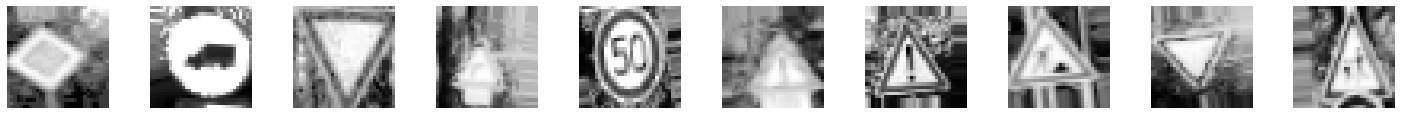

In [12]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,10,figsize=(20,5))
fig.tight_layout()
for i in range(10):
    image = X_batch[i].reshape(imageDimesions[0],imageDimesions[1])
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
plt.show()

In [13]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [14]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import  Conv2D, MaxPooling2D

batch_size_val = 50
epoch_val = 30

def myModel():
    no_of_filters = 60
    size_of_filter = (5, 5) # this is the kernel that move around the image to get the featurs
    size_of_filter2 = (3, 3)
    size_of_pool = (2, 2) # scale down all feature map to generalize more, to reduce overfitting
    no_of_nodes = 500
    model = Sequential()
    model.add((Conv2D(no_of_filters, size_of_filter, input_shape = (imageDimesions[0], imageDimesions[1],1),activation = 'relu')))
    model.add((Conv2D(no_of_filters, size_of_filter, activation= "relu")))
    model.add(MaxPooling2D(pool_size= size_of_pool))

    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation= "relu")))
    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation= "relu")))
    model.add(MaxPooling2D(pool_size= size_of_pool))

    model.add(Flatten())
    model.add(Dense(no_of_nodes, activation= "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation= "softmax"))

    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [15]:
# TRAIN MY MODEL

model =myModel()
print(model.summary())
history = model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),                                                                                      
                                steps_per_epoch= X_train.shape[0] / batch_size_val,
                                epochs = epoch_val,
                                validation_data= (X_validation, y_validation),
                                validation_steps = X_train.shape[0] / batch_size_val,
                                verbose= 1,
                                shuffle=1
                              ) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

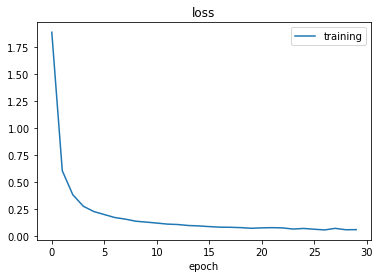

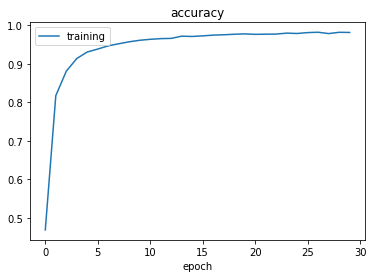

Test score: 0.13027891516685486
Test accuracy: 0.9743468165397644


In [18]:
# PLOT
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['training'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(['training'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score:", score[0])
print("Test accuracy:", score[1])



In [17]:
stop

NameError: ignored

In [ ]:
# SAVE MY MODEL
model.save("/content/drive/My Drive/traffic sign recognition/traffic_sign_recognition.h5")
print("Done")